In [21]:
from routing import TaxiRouting
import pandas as pd

In [50]:
# start, end, start_time, trip_time
trips = [(0,1,2,1),
         (3,2,0,1),
         (2,3,4,1),
         (2,1,2,2),
         (1,2,0,1)]
# start, end, trip_time
arcs = []
test = TaxiRouting(trips, arcs, dataframes=False, L=5, taxi_count=3)

In [51]:
test.optimize()
test.objective

5

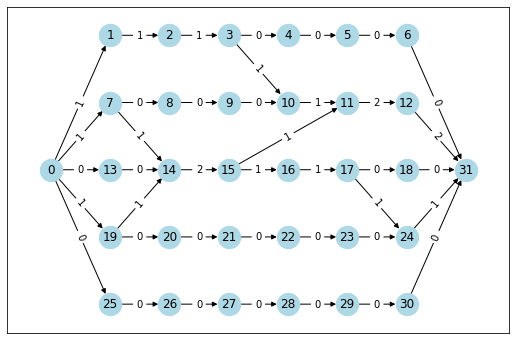

In [52]:
test.draw_graph()

In [17]:
trips = pd.read_csv('data/2013-09-01_manhattan_trip_data_discrete.csv').drop(columns='id')
nodes = pd.read_csv('data/nyc_nodes_manhattan.csv').drop(columns='Unnamed: 0')
arcs = pd.read_csv('data/nyc_links_manhattan.csv').drop(columns='Unnamed: 0')

In [18]:
test = TaxiRouting(trips, arcs, dataframes = True,
                   nodes = nodes, start_time = 17, end_time = 17.5, taxi_count = 1500)

In [19]:
test.optimize()
test.objective

2375

In [20]:
len(test.trips_df)

2375